In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

## Create a sensitivity map and orientation histogram for a specific feature over all training data

An individual feature in the descriptor can corresponds to various regions and orientations based on its keypoint.
<br>
Draw the feature's region for all frame batches in the training data in one figure.
<br>
Use transparent coloring to highlight the regions that were repeated more often.
<br>

Compute the feature's orientation for all training data.
<br>
Draw a histogram of the feature's orientation over all training data.

## Define the required functions

In [2]:
PI = 3.1415926535897932 # pi
gr = (1 + np.sqrt(5)) / 2 # golden ratio

# coordinates of a regular icosahedron vertices
verts = [
          [0,  1,  gr], #0
          [0, -1,  gr], #1
          [0,  1, -gr], #2
          [0, -1, -gr], #3

          [ 1,  gr, 0], #4
          [-1,  gr, 0], #5
          [ 1, -gr, 0], #6
          [-1, -gr, 0], #7

          [ gr, 0,  1], #8
          [-gr, 0,  1], #9
          [ gr, 0, -1], #10
          [-gr, 0, -1], #11
        ]

def discretize(start, stop):
    """
    Discretize a line into points on the coordinate gridlines.
    """
    diff = stop - start
    diff_unit = diff / np.linalg.norm(diff)
    num_pts = int(np.floor(np.linalg.norm(diff)))
    
    disc_pts = start.copy()
    disc_pts = disc_pts[:, np.newaxis]
    for i in range(num_pts):
        endi = start + (i+1)*diff_unit
        disc_pts = np.append(disc_pts, endi[:,np.newaxis], axis=1)
        
    return np.round(disc_pts)

def get_desel_region(desel_ind, batch_ind, batch_sz = 32, data_path = '../../data/features/sift3d/fvs_s1_with_kp/'):
    assert batch_ind >= 0 and batch_ind <= 1140
    assert desel_ind >= 0 and desel_ind <= 768

    # load a given batch's keypoint and descriptor
    # print('batch index:', batch_ind, '\nfeature index:', desel_ind)
    desc = np.loadtxt(data_path+'desc/fv_'+str(batch_ind)+'.csv', delimiter=',')
    keyp = np.loadtxt(data_path+'keys/fv_'+str(batch_ind)+'.csv', delimiter=',')
    
    # # construct the given frame batch
    # idx = np.arange(batch_ind-batch_sz+1, batch_ind+1, dtype=np.int32)
    # sample_batch = frames[idx]
    
    # compute the keypoint's location in the frame batch
    img_coor = lambda keyp, coor_i: int(keyp[coor_i] * (2**keyp[3]))
    kp_z = img_coor(keyp, 0)
    kp_y = img_coor(keyp, 1)
    kp_x = img_coor(keyp, 2)
    kp_s = keyp[4]
    
    # compute some required quantities
    kp_loc = np.array([kp_z, kp_y, kp_x])
    kp_ori = keyp[5:].reshape((3,3))
    win_rad = 2*kp_s # radius of the sphere around the keypoing where the descriptor is computed
    region_side = win_rad/np.sqrt(2)/2
    
    # compute desel's region coordinates relative to the keypoint
    desel_ori_rel = desel_ind%12 # 12 vertices of icosahedron
    desel_z_rel = desel_ind//12%4 - 2 # z comes first based on the toy example results. -2 shifts the indices to -2 to 1 range.
    desel_y_rel = desel_ind//12//4%4 - 2
    desel_x_rel = desel_ind//12//4//4 - 2
    desel_loc_rel = np.array([desel_z_rel, desel_y_rel, desel_x_rel])
    
    # compute the coordinates of the region's corners in the original coordinate system
    corners1_zyx = np.broadcast_to(desel_loc_rel[np.newaxis, :], (3,3)) * kp_ori * region_side
    corner1 = np.sum(corners1_zyx, axis=1, keepdims=False) + kp_loc
    deltas = kp_ori*region_side

    # discretize the delta vectors into a list of points with whole numbers as coordinates
    start = np.zeros(3)
    disc_z = discretize(start, deltas[:,0])
    disc_y = discretize(start, deltas[:,1])
    disc_x = discretize(start, deltas[:,2])
    # discretize the location of the corner of the region
    disc_corner1 = np.round(corner1)
    
    # make a list of all the points in the region (relative to the corner of the region)
    zyx_list = []
    for k in range(disc_z.shape[1]):
        yx_list = []
        for j in range(disc_y.shape[1]):
            x_list = []
            for i in range(disc_x.shape[1]):
                pt = disc_z[:,k] + disc_y[:,j] + disc_x[:,i] # coordinates of the desired point relative to the corner of the region
                pt += disc_corner1 # convert the coordinates to the original system
                x_list.append(pt)
            yx_list.extend(x_list)
        zyx_list.extend(yx_list)
        
    return zyx_list, kp_loc

def get_desel_ori_sphere(desel_ind, batch_ind, verts, batch_sz = 32, data_path = '../../data/features/sift3d/fvs_s1_with_kp/'):
    assert batch_ind >= 0 and batch_ind <= 1140
    assert desel_ind >= 0 and desel_ind <= 768

    # load a given batch's keypoint and descriptor
    # print('batch index:', batch_ind, '\nfeature index:', desel_ind)
    desc = np.loadtxt(data_path+'desc/fv_'+str(batch_ind)+'.csv', delimiter=',')
    keyp = np.loadtxt(data_path+'keys/fv_'+str(batch_ind)+'.csv', delimiter=',')
    
    # # construct the given frame batch
    # idx = np.arange(batch_ind-batch_sz+1, batch_ind+1, dtype=np.int32)
    # sample_batch = frames[idx]
    
    # compute the keypoint's location in the frame batch
    img_coor = lambda keyp, coor_i: int(keyp[coor_i] * (2**keyp[3]))
    kp_z = img_coor(keyp, 0)
    kp_y = img_coor(keyp, 1)
    kp_x = img_coor(keyp, 2)
    kp_s = keyp[4]
    
    # compute some required quantities
    kp_loc = np.array([kp_z, kp_y, kp_x])
    kp_ori = keyp[5:].reshape((3,3))
    win_rad = 2*kp_s # radius of the sphere around the keypoing where the descriptor is computed
    region_side = win_rad/np.sqrt(2)/2
    
    # compute desel's region coordinates relative to the keypoint
    desel_ori_rel = desel_ind%12 # 12 vertices of icosahedron
    desel_z_rel = desel_ind//12%4 - 2 # z comes first based on the toy example results. -2 shifts the indices to -2 to 1 range.
    desel_y_rel = desel_ind//12//4%4 - 2
    desel_x_rel = desel_ind//12//4//4 - 2
    desel_loc_rel = np.array([desel_z_rel, desel_y_rel, desel_x_rel])
    
    # compute vector connecting the origin to the vertex of desel (in rotated coordinates)
    desel_ori_vect_rel = verts[desel_ori_rel]
    
    # rotate desel's orientation by the keypoint's orientation
    desel_ori_vect = kp_ori @ desel_ori_vect_rel
    
    # compute theta and phi
    dv_x, dv_y, dv_z = desel_ori_vect
    
    # compute theta
    theta_rad = math.atan(np.sqrt(dv_x**2 + dv_y**2) / (dv_z+1e-6))
    theta_deg = np.round(theta_rad * 180 / PI, decimals=2)
    if theta_deg < 0:
        theta_deg += 180

    # compute phi
    phi_rad = math.atan(dv_y / (dv_x+1e-6))
    phi_deg = np.round(phi_rad * 180 / PI, decimals=2)
    if phi_deg < 0 and dv_y < 0:
        phi_deg += 360
    elif phi_deg < 0 and dv_y >= 0:
        phi_deg += 180
    elif phi_deg >= 0 and dv_y < 0:
        phi_deg += 180

    desel_ori_sphere = [theta_deg, phi_deg]
    
    return desel_ori_sphere

## Create the sensitivity map

In [3]:
# set user given parameters
desel_ind = 376 * 2
batch_sz = 32
data_path = '../../data/features/sift3d/fvs_s1_with_kp/'
save_id = '_'+str(desel_ind//2) # add to the filenames whenever we save any data in this notebook

train_fbatch_inds = np.loadtxt('../20_clustering/matrices/train_fbatch_inds.csv').astype(int)

In [4]:
# find region points
zyx_lists_train = []
kp_locs_train = []
for batch_ind in train_fbatch_inds:
    zyx_list, kp_loc = get_desel_region(desel_ind, batch_ind, batch_sz, data_path)
    zyx_lists_train.extend(zyx_list)
    kp_locs_train.append(kp_loc)

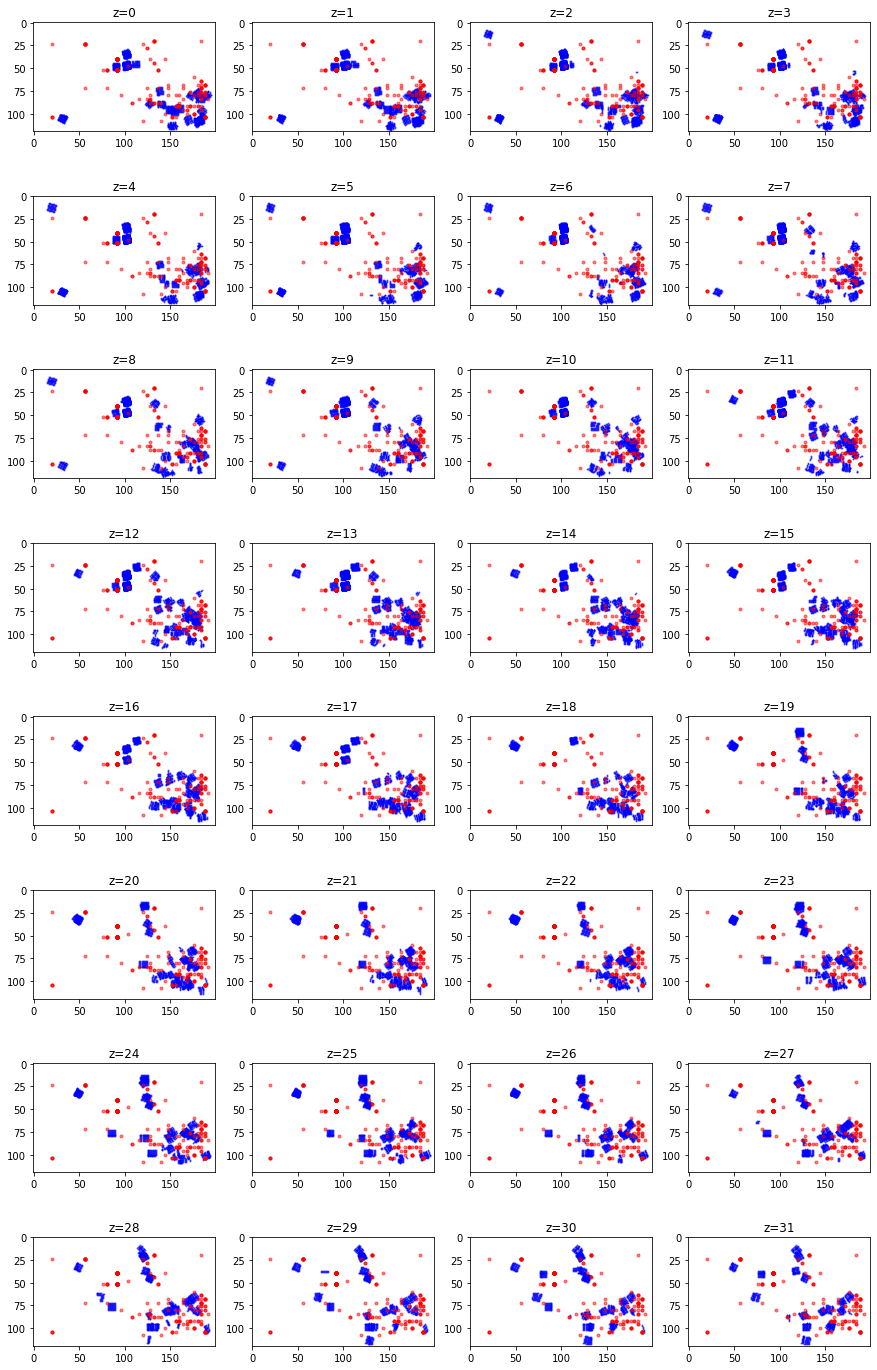

In [5]:
# visualize the frame batch as 32 two-dimentional frames
blank_batch = np.ones((32, 120, 200))
plt.figure(figsize=(15,25))

for n in range(batch_sz):
    ax = plt.subplot(8, 4, n+1)
    plt.imshow(blank_batch[n], cmap='binary')
    plt.title('z={}'.format(n))
    # plt.axis("off")
    # plt.axis("equal")
    
    # mark the correct region points on each frame
    for pt in zyx_lists_train:
        if pt[0] == n:
            ax.plot((pt[2]), (pt[1]), 'o', color='#0000ff80', markersize=1)

    # draw the keypoint's yx location on all frames
    for kp_loc in kp_locs_train:
        ax.plot((kp_loc[2]), (kp_loc[1]), 'o', color='#ff000080', markersize=3)

plt.savefig('image/sensemap_fv_'+str(desel_ind)+save_id+'.png',dpi=300, bbox_inches = "tight")

## Create the orientation histograms

In [8]:
desel_ori_sphere_list = []
for batch_ind in train_fbatch_inds:
    desel_ori_sphere = get_desel_ori_sphere(desel_ind, batch_ind, verts, batch_sz, data_path)
    desel_ori_sphere_list.append(desel_ori_sphere)
    
desel_ori_theta_list = [sphere[0] for sphere in desel_ori_sphere_list]
desel_ori_phi_list = [sphere[1] for sphere in desel_ori_sphere_list]

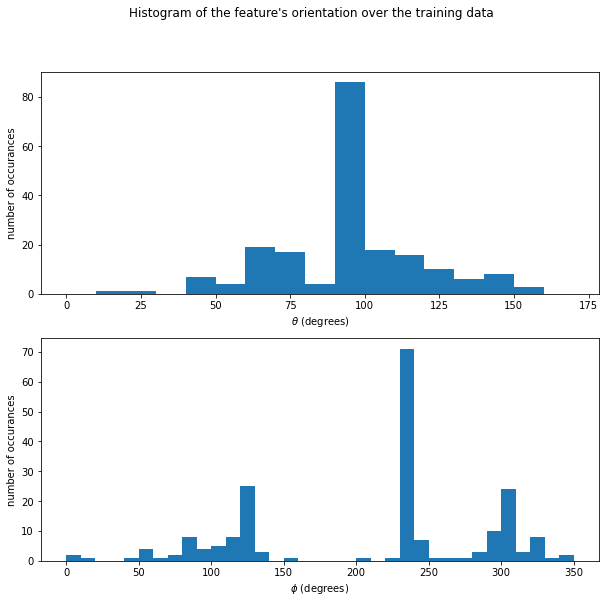

In [9]:
# draw histograms
plt.figure(figsize=(10,9))

plt.subplot(2,1,1)
_ = plt.hist(desel_ori_theta_list, range=(0, 180), bins=np.arange(0, 180, 10))
plt.xlabel('$\\theta$ (degrees)')
plt.ylabel('number of occurances')

plt.subplot(2,1,2)
_ = plt.hist(desel_ori_phi_list, range=(0, 360), bins=np.arange(0, 360, 10))
plt.xlabel('$\phi$ (degrees)')
plt.ylabel('number of occurances')

plt.suptitle('Histogram of the feature\'s orientation over the training data')

plt.savefig('image/orihist_fv_'+str(desel_ind)+save_id+'.png',dpi=300, bbox_inches = "tight")